# DATA 512 - A2 Bias in Data
Daniel White - November 1, 2018

## Overview

This assignment explores the bias in the number and quality of Wikipedia articles on politicians published for each country. Data on the quality of Wikipedia articles is collected using the ORES API which has documentation available here: (https://ores.wikimedia.org/v3/#!/scoring/get_v3_scores_context_revid_model)

The article quality data is collected and then merged with a dataset containing the population of each country. Potential bias is assessed by calculating the number of articles per capita and the percentage of high quality articles for each country.

## Data Collection

First, the necessary libraries are imported and the csv file containing the article data is loaded into memory. The article dataset can be found on Figshare (https://figshare.com/articles/Untitled_Item/5513449) in the page_data.csv file. 

Population data from 2018 is also loaded into memory and I changed the column headers for easier future reference. The population data can be accessed via Dropbox here: (https://www.dropbox.com/s/5u7sy1xt7g0oi2c/WPDS_2018_data.csv?dl=0). 

In [1]:
#Import libaries
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Import page data from csv file, downloaded from the link here. 
page_data = pd.read_csv('data/page_data.csv', index_col = None)
page_data.head()

,page,country,rev_id
0,Template:ZambiaProvincialMinisters,Zambia,235107991
1,Bir I of Kanem,Chad,355319463
2,Template:Zimbabwe-politician-stub,Zimbabwe,391862046
3,Template:Uganda-politician-stub,Uganda,391862070
4,Template:Namibia-politician-stub,Namibia,391862409


In [3]:
pop_df = pd.read_csv('data/WPDS_2018_data.csv')
pop_df.rename(columns = {'Geography': 'country',
                                     'Population mid-2018 (millions)': 'population'}, inplace = True)
pop_df.head()

,country,population
0,AFRICA,"1,284"
1,Algeria,42.7
2,Egypt,97
3,Libya,6.5
4,Morocco,35.2


A function is created in order to collect data on the article quality from the ORES API. Note that this code for the get_ores_data function was largely inspired by a similar function created in this repository (https://github.com/Ironholds/data-512-a2). This function takes a list of revision ids and passes them through the ORES API.

In [4]:
headers = {'User-Agent' : 'https://github.com/dwhite105', 'From' : 'dkwhite@uw.edu'}
def get_ores_data(revision_ids, headers):
    endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/?models={model}&revids={revids}'
    params = {'project' : 'enwiki',
              'model'   : 'wp10',
              'revids'  : '|'.join(str(x) for x in revision_ids)
              }
    api_call = requests.get(endpoint.format(**params))
    response = api_call.json()
    return response

The revision IDs are taken from the page data dataset and converted into a string. There are 47,197 IDs to run through the API, however, there is a limit to how many can be run through the API at one time. The code below does three things:

* Collects the rev_ids in increments of 100 to pass through the ORES API
* Extracts the article quality prediction for each ID. For articles without a prediction, it logs a NaN.
* Iterates through until all IDs are passed through the API, returning a list of all the predictions.

In [5]:
rev_ids = list(page_data.rev_id.apply(str))
rev_idx = 0
increment = 100
article_predictions = []
length = len(page_data)
while rev_idx < length:
    if rev_idx + increment > length:
        rev_ids_subset = rev_ids[rev_idx:len(page_data)]
    else: 
        rev_ids_subset = rev_ids[rev_idx:rev_idx+increment]    
    
    ores = get_ores_data(rev_ids_subset,headers)
    for i in rev_ids_subset:
        try:
            prediction = ores['enwiki']['scores'][i]['wp10']['score']['prediction']
        except KeyError:
            prediction = np.nan
        article_predictions.append(prediction)
    rev_idx = rev_idx + increment
article_predictions

[nan,
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'Stub',
 'St

## Data Processing

Next, a dataframe is constructed with each article name, article quality, revision ID, and country. 

In [6]:
page_df = pd.DataFrame({'country': page_data.country, 
              'article_name':page_data.page , 
              'revision_id': rev_ids,
              'article_quality' : article_predictions})
page_df.head()              

,article_name,article_quality,country,revision_id
0,Template:ZambiaProvincialMinisters,NaN,Zambia,235107991
1,Bir I of Kanem,Stub,Chad,355319463
2,Template:Zimbabwe-politician-stub,Stub,Zimbabwe,391862046
3,Template:Uganda-politician-stub,Stub,Uganda,391862070
4,Template:Namibia-politician-stub,Stub,Namibia,391862409


The article dataframe and population dataframe are then merged on a common country name. A left join is performed to preserve all the articles in the articles dataframe.

In [7]:
df = pd.merge(page_df, pop_df, how='left', on = 'country')
df.head()             

,article_name,article_quality,country,revision_id,population
0,Template:ZambiaProvincialMinisters,NaN,Zambia,235107991,17.7
1,Bir I of Kanem,Stub,Chad,355319463,15.4
2,Template:Zimbabwe-politician-stub,Stub,Zimbabwe,391862046,14
3,Template:Uganda-politician-stub,Stub,Uganda,391862070,44.1
4,Template:Namibia-politician-stub,Stub,Namibia,391862409,2.5


The dataframe snapshot above shows that some articles do not have predictions for article quality or were not matched up with a country during the merge. The observations that contain any NAs or missing data are removed from the dataset and the dataframe is saved as .csv file.

In [8]:
df1 = df.dropna()
df1.to_csv('data/wiki_article_quality_population_data.csv', index = False)
df1.head()

,article_name,article_quality,country,revision_id,population
1,Bir I of Kanem,Stub,Chad,355319463,15.4
2,Template:Zimbabwe-politician-stub,Stub,Zimbabwe,391862046,14
3,Template:Uganda-politician-stub,Stub,Uganda,391862070,44.1
4,Template:Namibia-politician-stub,Stub,Namibia,391862409,2.5
5,Template:Nigeria-politician-stub,Stub,Nigeria,391862819,195.9


A new column named 'high_quality' is created which indicates a 1 if the article is rated FA or GA, and a 0 if its not. A count of the values in this column show that 980 articles were deemed of high quality. 

In [9]:
df1['high_quality'] = np.where((df1.article_quality == 'FA') | (df1.article_quality == 'GA'),1,0)
df1.head()

/Users/danielwhite/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,article_name,article_quality,country,revision_id,population,high_quality
1,Bir I of Kanem,Stub,Chad,355319463,15.4,0
2,Template:Zimbabwe-politician-stub,Stub,Zimbabwe,391862046,14,0
3,Template:Uganda-politician-stub,Stub,Uganda,391862070,44.1,0
4,Template:Namibia-politician-stub,Stub,Namibia,391862409,2.5,0
5,Template:Nigeria-politician-stub,Stub,Nigeria,391862819,195.9,0


In [10]:
df1['high_quality'].value_counts()

0    43992
1      980
Name: high_quality, dtype: int64

The dataset is then grouped by country, counting the number of articles and the number of high quality articles. The number of articles per capita (millions) and the percentage of high quality articles are calculated as new columns in the dataframe.

In [11]:
# Group data and aggregate by country

country_articles = df1.groupby(['country'], as_index = False).agg({'article_name': 'count', 
                                                 'high_quality': 'sum', 
                                                 'population' : 'max'})
country_articles.rename(columns = {'article_name' : 'article_count',
                                  'high_quality' : 'quality_article_count'}, inplace = True)

#Remove commas from population, convert to integer
country_articles['population'] = country_articles['population'].str.replace(',','')
country_articles['population'] = country_articles['population'].apply(pd.to_numeric)

#Calculation of new columns
country_articles['articles_per_population'] = country_articles['article_count'] / (country_articles['population'])
country_articles['percent_quality_article'] = country_articles['quality_article_count'] / country_articles['article_count']
country_articles.head()


,country,article_count,quality_article_count,population,articles_per_population,percent_quality_article
0,Afghanistan,326,10,36.50,8.931507,0.030675
1,Albania,460,4,2.90,158.620690,0.008696
2,Algeria,119,2,42.70,2.786885,0.016807
3,Andorra,34,0,0.08,425.000000,0.000000
4,Angola,110,0,30.40,3.618421,0.000000


## Data Analysis

I created some exploratory visualizations below to get a better sense of the distribution of the data.

The first histogram shows the number of articles per country for all countries in the dataset. The data is left skewed, with most countrires having less than 250 articles. 

The second histogram shows the number of high quality articles per country. Again, the data shows some left skew with most countries having less than 10 high quality articles. 

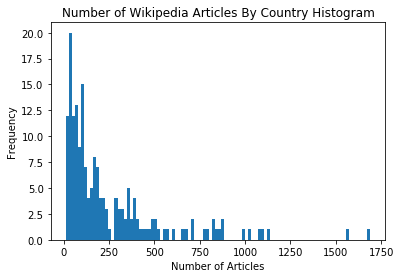

In [12]:
plt.hist(country_articles['article_count'], bins = 100)
plt.xlabel('Number of Articles')
plt.ylabel('Frequency')
plt.title('Number of Wikipedia Articles By Country Histogram')
plt.show()

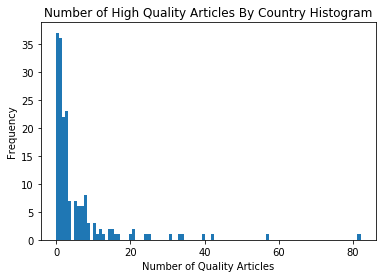

In [13]:
plt.hist(country_articles['quality_article_count'], bins = 100)
plt.xlabel('Number of Quality Articles')
plt.ylabel('Frequency')
plt.title('Number of High Quality Articles By Country Histogram')
plt.show()

Four tables are then created by sorted the values in the dataframe. This includes:
* 10 highest-ranked countries in terms of number of politician articles as a proportion of country population
* 10 lowest-ranked countries in terms of number of politician articles as a proportion of country population
* 10 highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country
* 10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country

(Table descriptions taken from A2 Bias in Data assignment page)

In [14]:
#Total articles per capita (calculated per million people)
top10_article_per_population = country_articles[
    ['country','articles_per_population','article_count','population']].sort_values(
    'articles_per_population', ascending = False).head(10)
bottom10_article_per_population = country_articles[
    ['country','articles_per_population','article_count','population']].sort_values(
    'articles_per_population').head(10)
top10_article_per_population.index = np.arange(1, len(top10_article_per_population)+1)
bottom10_article_per_population.index = np.arange(1, len(bottom10_article_per_population)+1)

#Percent of quality articles of total articles per country
top10_percent_quality_article = country_articles[
    ['country','percent_quality_article', 'quality_article_count','article_count']].sort_values(
    'percent_quality_article', ascending = False).head(10)
bottom10_percent_quality_article1 = country_articles[
    ['country','percent_quality_article', 'quality_article_count','article_count']].sort_values(
    ['percent_quality_article', 'article_count'], ascending = [True, False]).head(10)
bottom10_percent_quality_article2 = country_articles[
    ['country','percent_quality_article', 'quality_article_count','article_count']].sort_values(
    ['percent_quality_article', 'article_count'], ascending = [True, True]).head(10)
top10_percent_quality_article.index = np.arange(1, len(top10_percent_quality_article)+1)
bottom10_percent_quality_article1.index = np.arange(1, len(bottom10_percent_quality_article1)+1)
bottom10_percent_quality_article2.index = np.arange(1, len(bottom10_percent_quality_article1)+1)

### Top 10 Countries - Wikipedia Articles per Capita

The table below shows the number Wikipedia articles per capita in the dataset. Note that the column named article_per_population indicates the number of articles per million people. 

Not surprisingly, the list is mostly comprised of countries with very small populations. Many of the top entries on the list are small islands in the South Pacific. These could have more Wikipedia articles if they are considered territories of more populous countries (i.e. Marshall Islands is a state associated with the United States) The other countries listed are very small European countries. A large portion of Wikipedia contributors are European which could explain the disproportionate number of these articles.

In [15]:
top10_article_per_population

,country,articles_per_population,article_count,population
1,Tuvalu,5500.000000,55,0.01
2,Nauru,5300.000000,53,0.01
3,San Marino,2733.333333,82,0.03
4,Monaco,1000.000000,40,0.04
5,Liechtenstein,725.000000,29,0.04
6,Tonga,630.000000,63,0.10
7,Marshall Islands,616.666667,37,0.06
8,Iceland,515.000000,206,0.40
9,Andorra,425.000000,34,0.08
10,Federated States of Micronesia,380.000000,38,0.10


### Bottom 10 Countries - Wikipedia Articles per Capita

As expected, many of the countries in the bottom 10 for Wikipedia articles per capita are highly populous countries such as China and India. Though each have many articles, their population are so large that it brings down the ratio of articles per capita. Some more surprising inclusions on this list were Uzbekistan and Ethiopia. I am honestly not sure why these countries have so few articles in the dataset and it could be a question worth further investigation. North Korea was a interesting entry. Given the restrictions on communication with the outside world, it's not surprising that they have very few Wikipedia articles.

It's notable that the countries with the lowest articles per capita are all in Asia or Africa. Wikipedia editing is most predominant in North America and Europe which could explain this bias.

In [16]:
bottom10_article_per_population

,country,articles_per_population,article_count,population
1,India,0.719026,986,1371.3
2,Indonesia,0.806938,214,265.2
3,China,0.814321,1135,1393.8
4,Uzbekistan,0.881459,29,32.9
5,Ethiopia,0.976744,105,107.5
6,Zambia,1.412429,25,17.7
7,"Korea, North",1.523438,39,25.6
8,Thailand,1.691843,112,66.2
9,Bangladesh,1.941106,323,166.4
10,Mozambique,1.967213,60,30.5


### Top 10 Countries - Percentage of High Quality Wikipedia Articles

First, I constructed a histogram to better understand the distribution high quality article data. It appears the percentage of high quality articles is left skewed, with many countries having zero high quality articles.

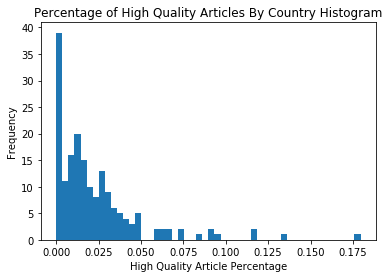

In [17]:
plt.hist(country_articles['percent_quality_article'], bins = 50)
plt.xlabel('High Quality Article Percentage')
plt.ylabel('Frequency')
plt.title('Percentage of High Quality Articles By Country Histogram')
plt.show()

The table below shows the percentage of Wikipedia articles that are 'high quality' according to the ORES API. I expected the top entries to be countries with a well-educated population. However, I was surprised to see North Korea here, given that it appeared on the list with the fewest number of articles. North Korea could have a high proportion of high quality articles because it receives a lot of attention in world politics. Saudi Arabia and Romania were the most surprising entries. I would conduct further research to understand why they have such a high percentage of quality articles. Many other entries were countries with a few high quality articles and a low overall article count. The United States would have been my guess for the top country listed, and it is \#9 overall.

In [18]:
top10_percent_quality_article

,country,percent_quality_article,quality_article_count,article_count
1,"Korea, North",0.179487,7,39
2,Saudi Arabia,0.134454,16,119
3,Central African Republic,0.117647,8,68
4,Romania,0.114943,40,348
5,Mauritania,0.096154,5,52
6,Bhutan,0.090909,3,33
7,Tuvalu,0.090909,5,55
8,Dominica,0.083333,1,12
9,United States,0.075160,82,1091
10,Benin,0.074468,7,94


### Bottom 10 Countries - Percentage of High Quality Wikipedia Articles

As shown in the histogram, there are 37 countries with zero high quality articles. I made two separate tables to better assess this trend. Both tables contain the countries with no high quality articles -- but the first is ordered by countries with the most articles and the second is ordered by countries with the fewest articles.

The first table is particularly interesting because Finland, Belgium, Moldova, Switzerland and Nepal are either populous or well-educated countries, but they all have no quality Wikipedia articles. This is very surprising given they have over 360 articles each in the dataset. It was interesting that many of these countries are in Europe. I expected the Wikipedia's North American and European bias would be evident in the number of high quality articles.  

The second table is mostly small countries, as expected. These countries have fewer article written about them overall so it is not surprising that they do not have many high quality articles.

In [19]:
bottom10_percent_quality_article1

,country,percent_quality_article,quality_article_count,article_count
1,Finland,0.0,0,572
2,Belgium,0.0,0,523
3,Moldova,0.0,0,426
4,Switzerland,0.0,0,407
5,Nepal,0.0,0,361
6,Uganda,0.0,0,188
7,Costa Rica,0.0,0,150
8,Tunisia,0.0,0,140
9,Slovakia,0.0,0,119
10,Angola,0.0,0,110


In [20]:
bottom10_percent_quality_article2

,country,percent_quality_article,quality_article_count,article_count
1,Barbados,0.0,0,14
2,Belize,0.0,0,16
3,Bahamas,0.0,0,20
4,Guyana,0.0,0,20
5,Sao Tome and Principe,0.0,0,22
6,Seychelles,0.0,0,22
7,Antigua and Barbuda,0.0,0,25
8,Zambia,0.0,0,25
9,Liechtenstein,0.0,0,29
10,Lesotho,0.0,0,30


## Conclusion

In summary, population seems to have a strong correlation with the number of Wikipedia articles written on each country. The data showed bias towards European countries having a disproportionately high number of articles written about them. Countries in Asia and Africa had fewer articles written about them per capita.

The percentage of high quality articles didn't have any obvious overarching trend. The countries with no high quality articles were a mixed bag of European countries (Finland, Belgium) and island nations with small populations (Barbados, Bahamas). Countries with a large percentage of high quality articles ranged from North Korea to the United States to Romania. This could be an interesting question for further research to better understand why countries have so few high quality articles and why some have so many.